In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.models as models
import torch.nn.functional as F
from PIL import Image
import os
import numpy as np
import cv2
from tqdm import tqdm

In [19]:
# Configuration
DEVICE = torch.device("mps" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "best_VGG_model_1.pth"  # Update with your model path

In [20]:
class VGG16BinaryClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super(VGG16BinaryClassifier, self).__init__()
        self.vgg16 = models.vgg16(pretrained=pretrained)
        for param in self.vgg16.features.parameters():
            param.requires_grad = True
        self.vgg16.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        return self.vgg16(x)

In [21]:
class OcclusionSensitivity:
    def __init__(self, model, window_size=32, stride=16):
        self.model = model
        self.window_size = window_size
        self.stride = stride
        
    def generate_heatmap(self, input_tensor, target_class=None):
        """Generate occlusion sensitivity heatmap"""
        with torch.no_grad():
            # Original prediction
            original_output = torch.sigmoid(self.model(input_tensor))
            original_prob = original_output.item()
            original_class = 1 if original_prob > 0.5 else 0
            target_class = target_class or original_class
            
            # Setup dimensions
            b, c, h, w = input_tensor.shape
            heatmap = torch.zeros((h, w), device=DEVICE)
            pad = self.window_size // 2
            
            # Pad input for complete coverage
            padded_input = F.pad(input_tensor, (pad, pad, pad, pad), value=0)
            
            # Slide occlusion window
            for y in tqdm(range(0, h, self.stride), desc="Generating occlusion map"):
                for x in range(0, w, self.stride):
                    # Create occluded version
                    occluded = padded_input.clone()
                    y_start = y + pad
                    x_start = x + pad
                    occluded[..., y_start:y_start+self.window_size, 
                            x_start:x_start+self.window_size] = 0
                    
                    # Get modified prediction
                    output = torch.sigmoid(self.model(occluded[..., pad:-pad, pad:-pad]))
                    current_prob = output.item()
                    
                    # Calculate impact score
                    if target_class == 1:
                        score = original_prob - current_prob
                    else:
                        score = current_prob - original_prob
                    
                    # Update heatmap
                    y_end = min(y + self.stride, h)
                    x_end = min(x + self.stride, w)
                    heatmap[y:y_end, x:x_end] += score
            
            # Normalize and return
            heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
            return heatmap.cpu().numpy()

In [22]:
def load_model(model_path, device):
    model = VGG16BinaryClassifier(pretrained=True)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device).eval()
    return model

In [23]:
def visualize_occlusion(model, image_path, transform, window_size=32, stride=16):
    # Load and process image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(DEVICE)
    
    # Generate heatmap
    occlude = OcclusionSensitivity(model, window_size=window_size, stride=stride)
    heatmap = occlude.generate_heatmap(input_tensor)
    
    # Process visualizations
    image_np = np.array(image)
    heatmap = cv2.resize(heatmap, image.size)
    
    # Create heatmap overlay
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_INFERNO)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Blend with original image
    blended = cv2.addWeighted(image_np, 0.7, heatmap_colored, 0.3, 0)
    
    return image, heatmap, heatmap_colored, blended

In [24]:
def visualize_multiple_occlusion(model, image_paths, transform, num_images=5, figsize=(20, 15), window_size=32, stride=16):
    results = []
    for img_path in image_paths[:num_images]:
        results.append(visualize_occlusion(model, img_path, transform, window_size, stride=16))
    
    # Plot results
    fig, axes = plt.subplots(num_images, 4, figsize=figsize)
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    
    for idx, (image, heatmap, heatmap_colored, blended) in enumerate(results):
        axes[idx, 0].imshow(image)
        axes[idx, 0].set_title(f"Original {idx+1}")
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(heatmap, cmap='inferno')
        axes[idx, 1].set_title(f"Heatmap {idx+1}")
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(heatmap_colored)
        axes[idx, 2].set_title(f"Color Map {idx+1}")
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(blended)
        axes[idx, 3].set_title(f"Blended {idx+1}")
        axes[idx, 3].axis('off')
    
    plt.tight_layout()
    plt.show()
    return results

/var/folders/xw/pr4fd47s1y50xqg4b8qxdsk80000gn/T/ipykernel_7431/1512286004.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, m

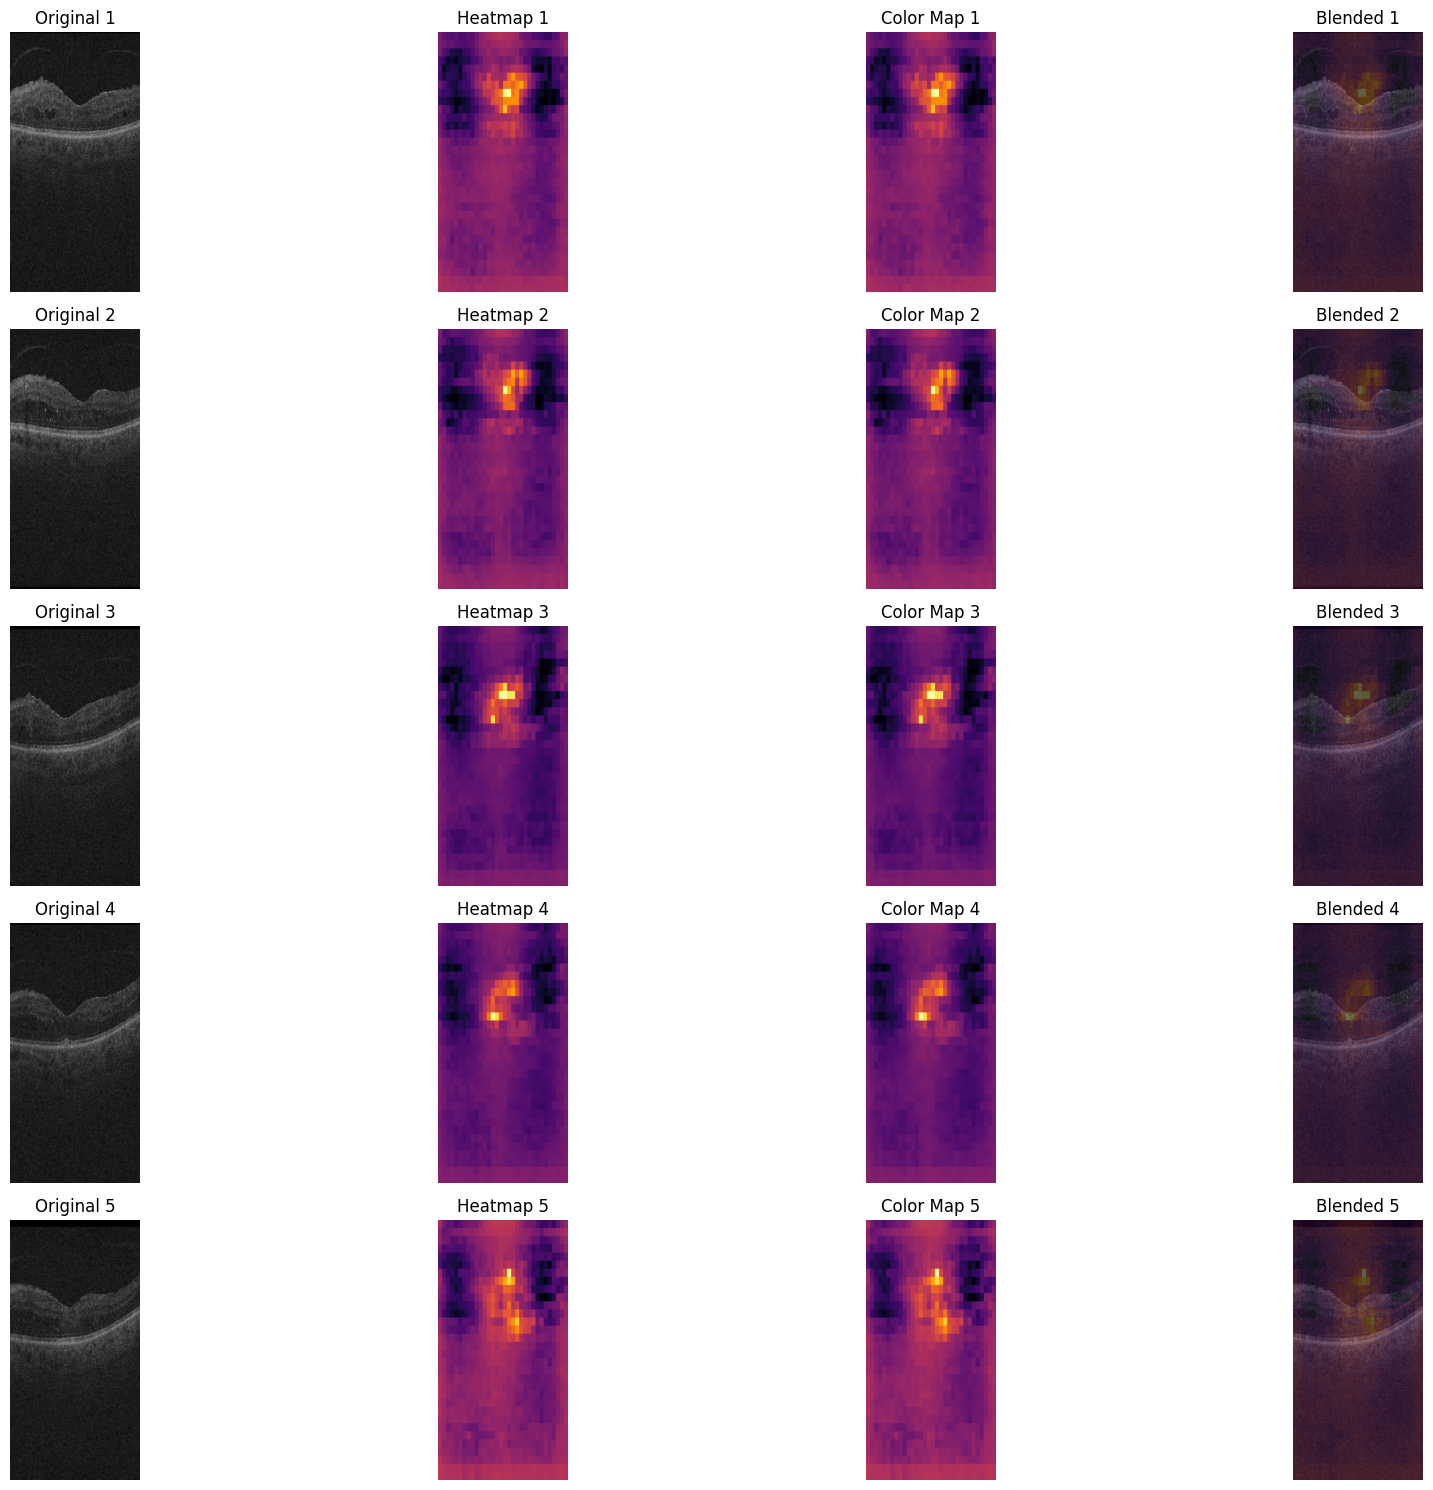

In [26]:
# Example Usage
if __name__ == "__main__":
    # Load model
    model = load_model(MODEL_PATH, DEVICE)
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Get sample images
    sample_images = [
        "image1.jpg",
        "image2.jpg",
        "image3.jpg",
        "image4.jpg",
        "image5.jpg"
        # Add your image paths here
    ]
    
    # Generate visualizations
    results = visualize_multiple_occlusion(
        model=model,
        image_paths=sample_images,
        transform=transform,
        num_images=5,
        window_size=40,  # Adjust based on your image features
        stride=20
    )